# BAPE Algorithm Example

---

In this notebook, I work through an example using the "Bayesian Active Learning for Posterior Estimation" (BAPE) algorithm developed by Kandasamy et al. (2015).  The "forward model" I will use in this example is the Rosenbrock function likelihood examined in Wang & Li (2017).  

Note: running this notebook with cache = True will create 10 large hdf5 files that hold the MCMC chains!

In [1]:
%matplotlib inline

from approxposterior import approx, likelihood as lh, gpUtils as gpu, utility as ut

import george
import corner
import emcee
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update({'font.size': 18})

# Tidy up the notebook (I'm not sweeping errors under the rug, I swear!)
import warnings
warnings.filterwarnings('ignore')

/Users/dflemin3/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


**First, define model parameters.**

---

In [2]:
# Define algorithm parameters
m0 = 50                           # Initial size of training set
m = 20                            # Number of new points to find each iteration
nmax = 3                          # Maximum number of iterations
bounds = ((-5,5), (-5,5))         # Prior bounds
algorithm = "BAPE"                # Use the Kandasamy et al. (2015) formalism

# emcee MCMC parameters
samplerKwargs = {"nwalkers" : 20}        # emcee.EnsembleSampler parameters
mcmcKwargs = {"iterations" : int(1.0e4)} # emcee.EnsembleSampler.run_mcmc parameters

**Create a Gaussian Process Object using george**

---

In [3]:
# Generate initial conditions using Latin Hypercube sampling over parameter bounds
theta = ut.latinHypercubeSampling(m0, bounds, criterion="maximin")

# Evaluate forward model log likelihood + lnprior for each theta
y = np.zeros(len(theta))
for ii in range(len(theta)):
    y[ii] = lh.rosenbrockLnlike(theta[ii]) + lh.rosenbrockLnprior(theta[ii])

### Initialize GP ###
gp = gpu.defaultGP(theta, y, order=None, white_noise=-1)

**Initialize object with required parameters**

---

In [4]:
# Initialize object using the Wang & Li (2017) Rosenbrock function example
ap = approx.ApproxPosterior(theta=theta,
                            y=y,
                            gp=gp,
                            lnprior=lh.rosenbrockLnprior,
                            lnlike=lh.rosenbrockLnlike,
                            priorSample=lh.rosenbrockSample,
                            algorithm=algorithm,
                            bounds=bounds)

Here, the forward model is wrapped up into the lnlike, or log-likelihood function.  This function evaluates the forward model and returns the log-likelihood of the forward model output.  This is the function we seek to call as *few* times as possible given how computationally expensive it is.  If you're not using a computationally expensive model (run times of less that a few minutes), you probably do not need to use this code!

The other functions, lnprior and prior_sample, evaluate the prior probability of a data point and yield samples from the prior probability distributions, respectively.

**With everything designated and initialized, run the algorithm!**

---

Note that with cache = True, approxposterior will create a apRunii.h5 file for each iteration ii.  These files, created by emcee, stores all the MCMC chain information.

In [5]:
# Run!
ap.run(m=m, nmax=nmax, estBurnin=True, mcmcKwargs=mcmcKwargs, 
       cache=True, samplerKwargs=samplerKwargs, verbose=False)

**Let's see what the joint and marginal posterior distributions look like for a few iterations.**

---

Below, I plot the joint and marginal posterior probability distributions.  The red points indicate where in parameter space the BAPE algorithm evaluated the forward model to improve its predictive ability.

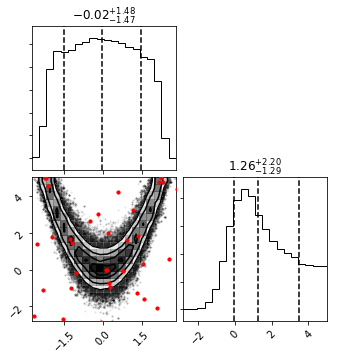

In [6]:
# 0th iteration...
reader = emcee.backends.HDFBackend(ap.backends[0])
samples = reader.get_chain(discard=ap.iburns[0], flat=True, thin=ap.ithins[0])

fig = corner.corner(samples, quantiles=[0.16, 0.5, 0.84], show_titles=True, 
                    scale_hist=True, plot_contours=True);

# Plot where forward model was evaluated
fig.axes[2].scatter(ap.theta[:(m0+m),0], ap.theta[:(m0+m),1], s=10, color="red", zorder=20)

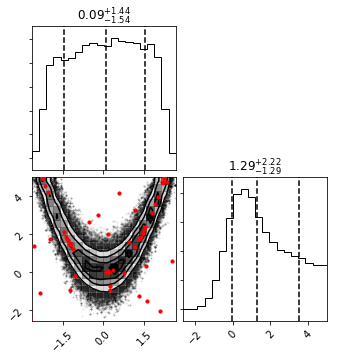

In [7]:
# Final iteration!
reader = emcee.backends.HDFBackend(ap.backends[-1])
samples = reader.get_chain(discard=ap.iburns[-1], flat=True, thin=ap.ithins[-1])

fig = corner.corner(samples, quantiles=[0.16, 0.5, 0.84], show_titles=True, 
                    scale_hist=True, plot_contours=True);

# Plot where forward model was evaluated
fig.axes[2].scatter(ap.theta[:,0], ap.theta[:,1], s=10, color="red", zorder=20)

The posteriors look great and BAPE only evaluated the forward model in high likelihood regions of parameter space!